In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
df = pd.read_csv('data.csv')
#df = df["Close"]
#df.info()
#df["Close"].plot()


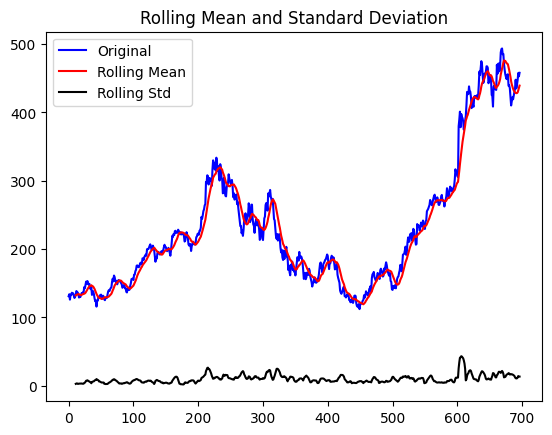

p-value: 0.9499013922396117


In [116]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    adf_test = adfuller(timeseries)
    print(f'p-value: {adf_test[1]}') #not stationary
    
test_stationarity(df["Close"])

<Figure size 640x480 with 0 Axes>

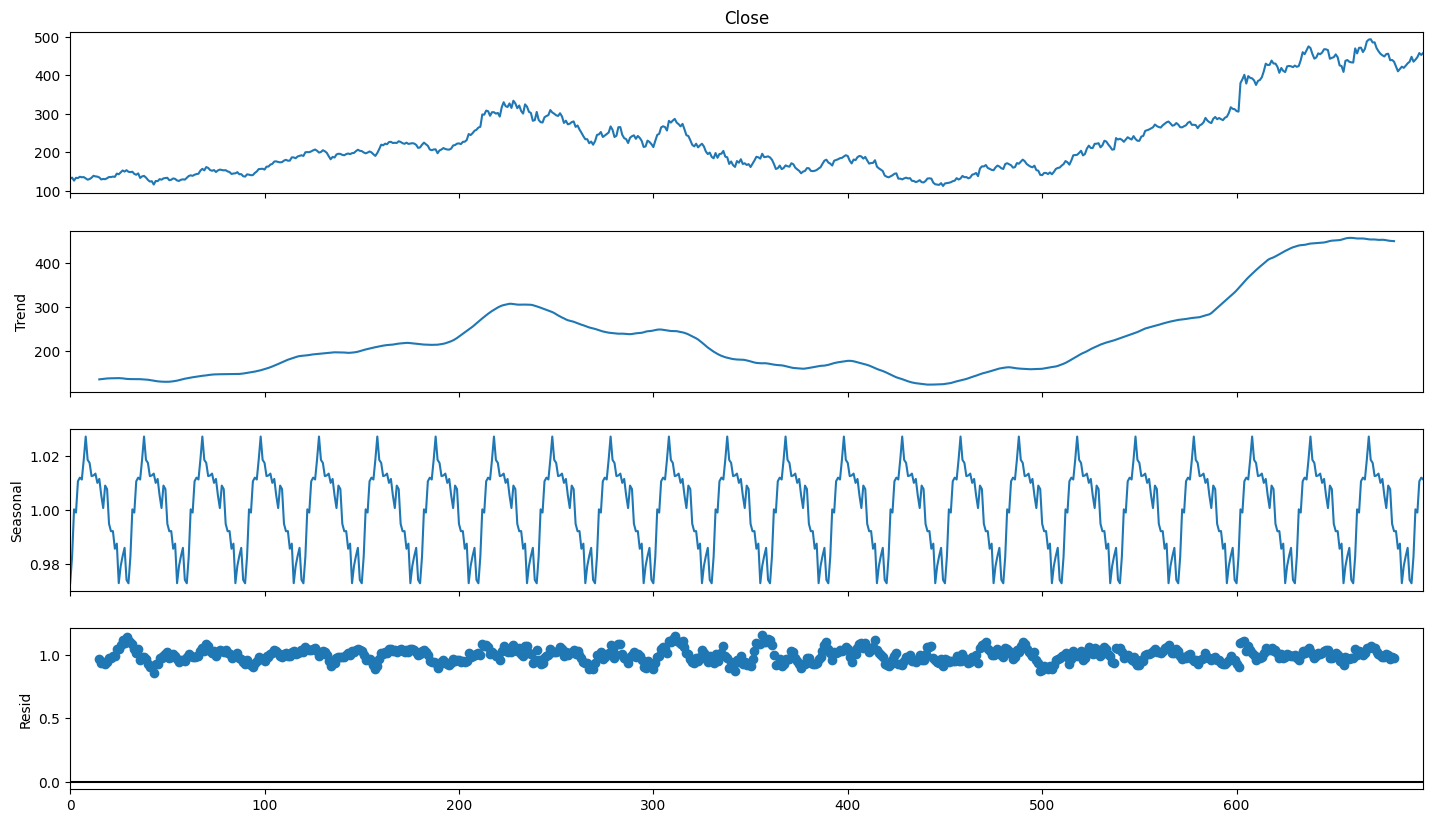

In [117]:
result = seasonal_decompose(df["Close"], model='multiplicative', period =30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

Differencing using log

p-value: 0.0


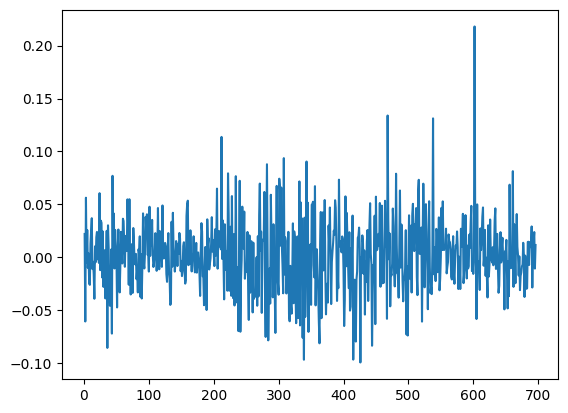

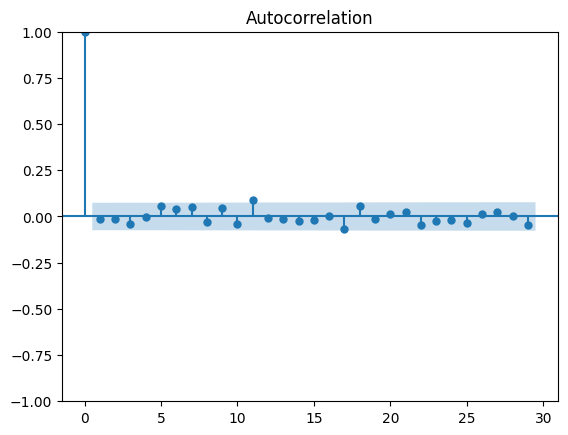

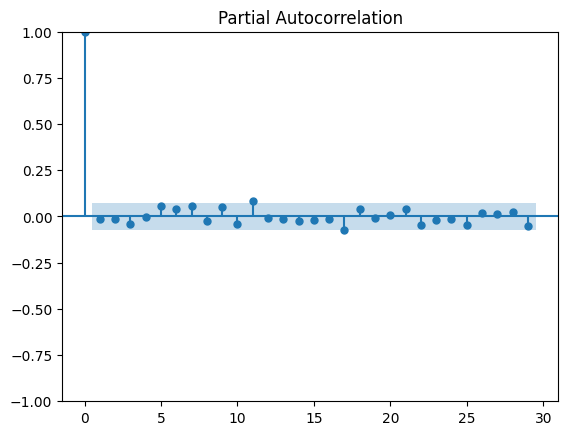

In [120]:
def make_logdiff(df):
    df_logdiff = np.log(df["Close"]) - np.log(df["Close"].shift(1))
    return df_logdiff.dropna()

df_logdiff = make_logdiff(df)
df_logdiff.plot()
acf_original = plot_acf(df_logdiff)
pacf_original = plot_pacf(df_logdiff)
adf_test = adfuller(df_logdiff)
print(f'p-value: {adf_test[1]}') #differenced data is stationary

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


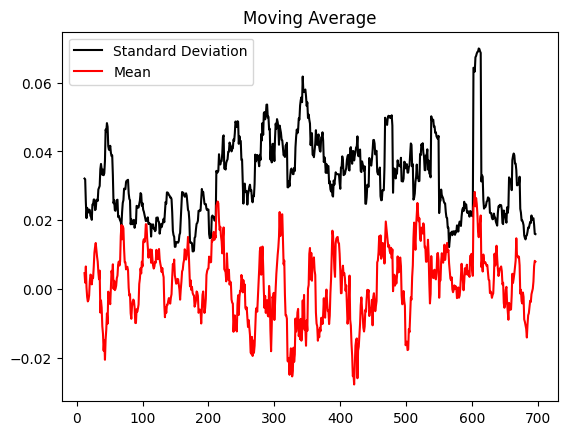

In [86]:
moving_avg = df_logdiff.rolling(12).mean()
std_dev = df_logdiff.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show() # looks p stationary to me

dataset split

In [122]:
train_data, test_data = df[3:int(len(df_logdiff)*0.9)], df[int(len(df_logdiff)*0.9):]

Auto ARIMA

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2414.710, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-2412.732, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-2412.733, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-2410.733, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2414.384, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.269 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  622
Model:                        SARIMAX   Log Likelihood                1208.355
Date:                Wed, 18 Oct 2023   AIC                          -2414.710
Time:                        14:42:47   BIC                          -2410.277
Sample:                             0   HQIC                         -2412.987
                                - 622                                  

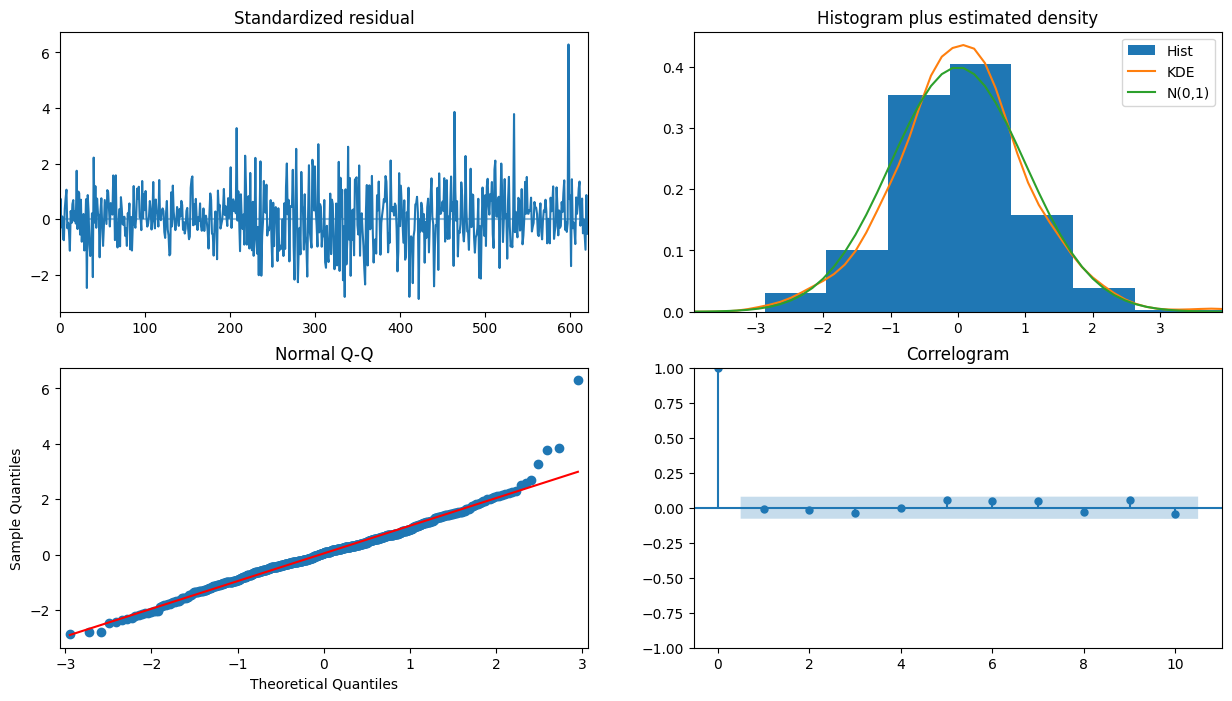

In [123]:
model_autoARIMA = auto_arima(make_logdiff(train_data), start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [128]:
model = ARIMA(make_logdiff(train_data), order=(0,1,0))  
fitted = model.fit()  
print(fitted.summary())
# Forecast
fitted.forecast(623, alpha=0.05)  # 95% conf

endog = train_data['Close']
exog = train_data.drop('Close', axis=1)  # removing the 'Close' column to use the rest as exogenous variables

import statsmodels.api as sm
model = sm.tsa.SARIMAX(endog, exog=exog, order=(0,1,0))
model_fit = model.fit(disp=False)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  622
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 988.859
Date:                Wed, 18 Oct 2023   AIC                          -1975.718
Time:                        14:47:10   BIC                          -1971.286
Sample:                             0   HQIC                         -1973.995
                                - 622                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0024      0.000     22.505      0.000       0.002       0.003
Ljung-Box (L1) (Q):                 152.58   Jarque-Bera (JB):                42.70
Prob(Q):                              0.00   Pr

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [30]:
from statsmodels.tsa.arima.model import ARIMA

# Define the ARIMA model
model = ARIMA(df_train["Close"], order=(1,1,1))
result = model.fit(disp=-1)

# Plot residual errors
residuals = pd.DataFrame(result.resid)
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

print(residuals.describe())

# Forecast
forecast = result.forecast(steps=len(df_test))
df_test['Forecast'] = forecast
df_train['Close'].plot(figsize=(12,8), legend=True)
df_test['Forecast'].plot(legend=True)

TypeError: ARIMA.fit() got an unexpected keyword argument 'disp'